# Calculates average mutual recall, precision, f-score for sentence level annotations

This notebook calculates the average mutual recall, precision and f-score scores for sentence level annotations from export of the InCepTion tool. These exports are stored in the IAA folder for five groups of two annotators: G1, G2, G3, G4, G5. Each group has two tsv files in their subfolder.

InCepTion stores the annotations on rows for tokens. Rows have a document identifier, a sentence-token identifier and the annotation label. If there is no annotation, the "_" is given.

We process the data group by group and calculte the Kappa scores for each label separately. Annotations are aggregated at the sentence level. 
If there are multiple labels per sentence, we select the label under investigation from either annotator and check if the other annotator has the same label or some other label.

The results are aggregated in a Pandas frame and saved to a CSV file at the end after processing all the annotators.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html


In [2]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import os, random, glob, json, re
from collections import Counter
import util

global1 = []
global2 = []
globalkey = []
globalgroup = []

results_df = pd.DataFrame(columns=['Label', 'G1', 'G2', 'G3', 'G4', 'G5'])
cnts_df = pd.DataFrame(columns=['Label', 'G1', 'G2', 'G3', 'G4', 'G5'])

In [3]:
alllabels=sorted(['.B152: Stemming','.B455: Inspanningstolerantie', '.D450: Lopen en zich verplaatsen','.D840-859: Beroep en werk','FAC 0', 'FAC 1', 'FAC 2', 'FAC 3', 'FAC 4', 'FAC 5', 'STM 0', 'STM 1','STM 2','STM 3','STM 4' ,
        'INS 0' , 'INS 1', 'INS 2', 'INS 3', 'INS 4', 'BER 0', 'BER 1','BER 2','BER 3','BER 4', 'X', '_'])

In [4]:
### Given two annotators
group='G1'
base="./IAA/"+group+"/IAA_"
name1="avelli"
name2="vervaart"

print('annotator:',name1)
file1=base+name1+".tsv"
df1 = pd.read_csv(file1,sep="\t")
print(df1.info())
print(df1.head())
print()
df1['annotation'].fillna("_")

print('annotator:',name2)
file2=base+name2+".tsv"
df2 = pd.read_csv(file2,sep="\t")
print(df2.info())
print(df2.head())
df2['annotation'].fillna("_")

annotator: avelli
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   note_id        4255 non-null   object
 1   sen_id-tok_id  4255 non-null   object
 2   annotation     3681 non-null   object
dtypes: object(3)
memory usage: 99.9+ KB
None
                                             note_id sen_id-tok_id annotation
0  VUmc--5113--1834251--414676213--2020-04-13--q1...           1-1          _
1  VUmc--5113--1834251--414676213--2020-04-13--q1...           1-2          _
2  VUmc--5113--1834251--414676213--2020-04-13--q1...           2-1          _
3  VUmc--5113--1834251--414676213--2020-04-13--q1...           2-2          _
4  VUmc--5113--1834251--414676213--2020-04-13--q1...           2-3          _

annotator: vervaart
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 3 columns):
 #   Column         

0       _
1       _
2       _
3       _
4       _
       ..
4250    _
4251    _
4252    _
4253    _
4254    _
Name: annotation, Length: 4255, dtype: object

### Clean the annotations

In [5]:
print('DF1')
df1= util.clean_df(df1)
print('DF2')
df2= util.clean_df(df2)

DF1
Length: 4255
DF2
Length: 4255


The number of token ids should be the same across the two annotators:

In [6]:
print('Number of token ids', len(util.get_token_ids(df1)))
print('Number of token ids', len(util.get_token_ids(df2)))

Number of token ids 4255
Number of token ids 4255


## Getting the  annotations at the sentence level

We get some statistics on the distribution of the annotations at the sentence level

In [7]:
sentence_label_dict1 = util.sentence_anno(df1)
print('Number of sentences:',len(sentence_label_dict1))

sentence_label_dict2 = util.sentence_anno(df2)
print('Number of sentences:',len(sentence_label_dict1))

Number of sentences: 731
Number of sentences: 731


In [8]:
key1=list(sentence_label_dict1.keys())[7]
key2=list(sentence_label_dict2.keys())[7]
print(key1)
print(sentence_label_dict1[key1])
print(key2)
print(sentence_label_dict2[key2])

VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_8
['_', '_', '_', '_']
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_8
['_', '_', '_', '_']


Next, we need to make these annotations unique sets.

In [9]:
setdict1 = util.get_sentence_set_anno_dict(sentence_label_dict1)
setdict2 = util.get_sentence_set_anno_dict(sentence_label_dict2)

Check if this worked out and sentence ids are correctly aligned

In [10]:
keys1=setdict1.items()
keys2=list(setdict2.items())

cnt = 0
for key1, value1 in setdict1.items():
    value2=setdict2[key1]
    if not (value1=={'_'} and (value2=={'_'})):
        print(key1, value1, value2)
        cnt+=1
        if (cnt==10):
            break

VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_19 {'target'} {'target'}
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_20 {'target'} {'target'}
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_21 {'target'} {'target'}
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_22 {'target'} {'target', '_'}
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_23 {'target'} {'_'}
VUmc--5113--1834251--414676213--2020-04-13--q1q2--Search1_24 {'target'} {'_'}
VUmc--5122--1834251--419112434--2020-05-01--q1q2--Search1_1 {'_'} {'type\\_Background'}
VUmc--5122--1834251--419112434--2020-05-01--q1q2--Search1_2 {'_'} {'type\\_Background'}
VUmc--5122--1834251--419112434--2020-05-01--q1q2--Search1_3 {'_'} {'type\\_Background'}
VUmc--5122--1834251--419112434--2020-05-01--q1q2--Search1_4 {'_'} {'type\\_Background'}


## Anno1 against Anno2

In [11]:
anno1 , anno2 = util.get_annotations_for_sentences(setdict1, setdict2, alllabels)
global1 =anno1
global2 =anno2
print(len(global1))
print(len(global2))

731
731
Proportion of line mismatches: 0.0
707
707


In [12]:
adf1 = pd.DataFrame(anno1, columns=['Labels'])
index = adf1[adf1['Labels'] == '_'].index
# Delete these row indexes from dataFrame
adf1.drop(index , inplace=True)
adf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 28 to 562
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Labels  26 non-null     object
dtypes: object(1)
memory usage: 416.0+ bytes


In [13]:
adf1.head()

,Labels
28,.D450: Lopen en zich verplaatsen
29,.B455: Inspanningstolerantie
32,.D450: Lopen en zich verplaatsen
33,FAC 4
34,.D450: Lopen en zich verplaatsen


/Users/piek/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


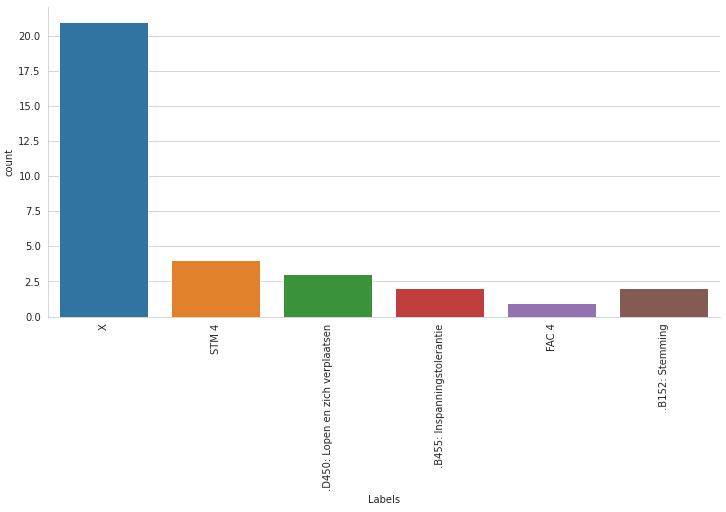

In [169]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot("Labels", data=adf1, aspect=2, kind="count")
    g.set_xticklabels(rotation=90)

In [14]:
from sklearn.metrics import classification_report
report1 = classification_report(anno1,anno2,digits = 3)

print(report1)

                                  precision    recall  f1-score   support

                 .B152: Stemming      0.667     0.667     0.667         3
    .B455: Inspanningstolerantie      1.000     0.125     0.222         8
.D450: Lopen en zich verplaatsen      0.000     0.000     0.000         8
                           FAC 4      1.000     0.333     0.500         3
                           STM 3      0.000     0.000     0.000         0
                           STM 4      0.000     0.000     0.000         4
                               X      0.000     0.000     0.000         0
                               _      0.982     0.935     0.958       681

                        accuracy                          0.907       707
                       macro avg      0.456     0.258     0.293       707
                    weighted avg      0.964     0.907     0.930       707



/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
adf2 = pd.DataFrame(anno2, columns=['Labels'])
index = adf2[adf2['Labels'] == '_'].index
# Delete these row indexes from dataFrame
adf2.drop(index , inplace=True)
adf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 18 to 540
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Labels  58 non-null     object
dtypes: object(1)
memory usage: 928.0+ bytes


/Users/piek/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


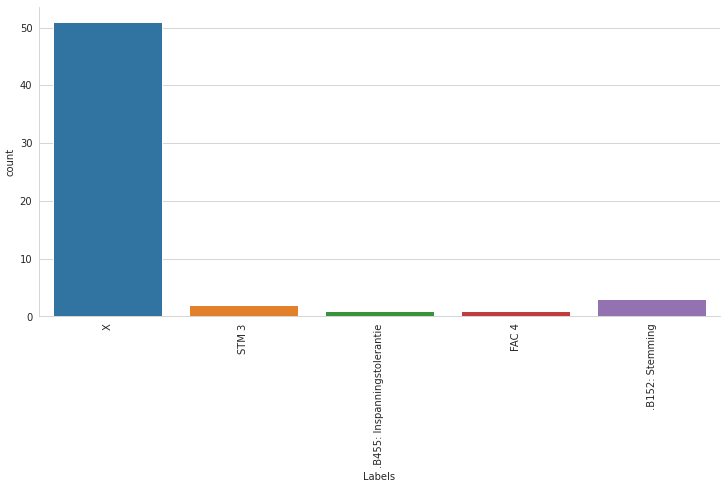

In [16]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot("Labels", data=adf2, aspect=2, kind="count")
    g.set_xticklabels(rotation=90)

In [18]:
report2 = classification_report(anno2,anno1,digits = 3)

print(report2)

                                  precision    recall  f1-score   support

                 .B152: Stemming      0.667     0.667     0.667         3
    .B455: Inspanningstolerantie      0.125     1.000     0.222         1
.D450: Lopen en zich verplaatsen      0.000     0.000     0.000         0
                           FAC 4      0.333     1.000     0.500         1
                           STM 3      0.000     0.000     0.000         2
                           STM 4      0.000     0.000     0.000         0
                               X      0.000     0.000     0.000        51
                               _      0.935     0.982     0.958       649

                        accuracy                          0.907       707
                       macro avg      0.258     0.456     0.293       707
                    weighted avg      0.862     0.907     0.883       707



In [19]:
labels = anno1+anno2
labelset = sorted(set(labels))
print(labelset)

['.B152: Stemming', '.B455: Inspanningstolerantie', '.D450: Lopen en zich verplaatsen', 'FAC 4', 'STM 3', 'STM 4', 'X', '_']


In [20]:

cf_matrix = confusion_matrix(anno1, anno2, list(labelset))
print(cf_matrix)
#plot_confusion_matrix(anno1, anno2, list(labelset))  
#plt.show()

[[  2   0   0   0   0   0   0   1]
 [  0   1   0   0   0   0   2   5]
 [  0   0   0   0   0   0   3   5]
 [  0   0   0   1   0   0   2   0]
 [  0   0   0   0   0   0   0   0]
 [  1   0   0   0   2   0   0   1]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  44 637]]


/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['.B152: Stemming', '.B455: Inspanningstolerantie', '.D450: Lopen en zich verplaatsen', 'FAC 4', 'STM 3', 'STM 4', 'X', '_'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


0 FAC 4
1 STM 3
2 STM 4
3 X
4 _


<AxesSubplot:>

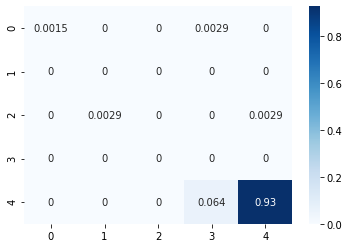

In [16]:

#sns.heatmap(cf_matrix, annot=True)

for i, label in enumerate(labelset):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues')

## G2

Length: 6464
Length: 6464
1101
1101
Proportion of line mismatches: 0.0
anno1 933
anno2 933
global1 1621
global2 1621
              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         1
       FAC 2      0.000     0.000     0.000         1
       FAC 3      0.000     0.000     0.000         0
       STM 0      0.000     0.000     0.000         0
       STM 1      0.000     0.000     0.000         2
       STM 2      0.000     0.000     0.000         1
       STM 4      0.000     0.000     0.000         1
           X      0.000     0.000     0.000         0
           _      0.995     0.866     0.926       927

    accuracy                          0.861       933
   macro avg      0.111     0.096     0.103       933
weighted avg      0.989     0.861     0.920       933

              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         0
       FAC 2      0.000     0.000     0.000         0
       FAC 3   

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['FAC 0', 'FAC 2', 'FAC 3', 'STM 0', 'STM 1', 'STM 2', 'STM 4', 'X', '_'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:>

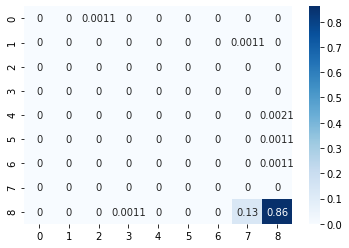

In [17]:
### Given two annotators
group='G2'
base="./IAA/"+group+"/IAA_"
name1="bos"
name2="meskers"

file1=base+name1+".tsv"
df1 = pd.read_csv(file1,sep="\t")
df1['annotation'].fillna("_")

file2=base+name2+".tsv"
df2 = pd.read_csv(file2,sep="\t")
df2['annotation'].fillna("_")

df1= util.clean_df(df1)
df2= util.clean_df(df2)

sentence_label_dict1 = util.sentence_anno(df1)
sentence_label_dict2 = util.sentence_anno(df2)

setdict1 = util.get_sentence_set_anno_dict(sentence_label_dict1)
setdict2 = util.get_sentence_set_anno_dict(sentence_label_dict2)

anno1 , anno2 = util.get_annotations_for_sentences(setdict1, setdict2, alllabels)
global1 = global1+anno1
global2 = global2+anno2
print('anno1', len(anno1))
print('anno2', len(anno2))


print('global1',len(global1))
print('global2',len(global2))
report1 = classification_report(anno1,anno2,digits = 3)
print(report1)
report2 = classification_report(anno2,anno1,digits = 3)
print(report2)

labels = anno1+anno2
labelset = sorted(set(labels))
cf_matrix = confusion_matrix(anno1, anno2, list(labelset))
print(cf_matrix)
for i, label in enumerate(labelset):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues')

## G3

Length: 5968
Length: 5968
1046
1046
Proportion of line mismatches: 0.0
anno1 1042
anno2 1042
global1 2663
global2 2663
              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         0
       FAC 1      0.000     0.000     0.000         1
       FAC 2      0.000     0.000     0.000         1
       INS 1      1.000     1.000     1.000         1
       STM 1      0.000     0.000     0.000         1
       STM 3      0.000     0.000     0.000         1
       STM 4      1.000     1.000     1.000         1
           X      0.000     0.000     0.000         0
           _      0.998     0.970     0.984      1036

    accuracy                          0.966      1042
   macro avg      0.333     0.330     0.332      1042
weighted avg      0.994     0.966     0.980      1042

              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         1
       FAC 1      0.000     0.000     0.000         0
       FAC 2 

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['FAC 0', 'FAC 1', 'FAC 2', 'INS 1', 'STM 1', 'STM 3', 'STM 4', 'X', '_'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:>

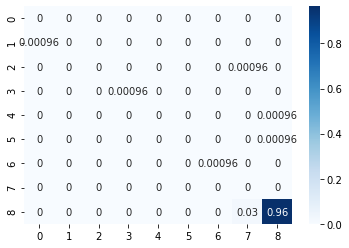

In [18]:
### Given two annotators
group='G3'
base="./IAA/"+group+"/IAA_"
name1="katsburg"
name2="opsomer"

file1=base+name1+".tsv"
df1 = pd.read_csv(file1,sep="\t")
df1['annotation'].fillna("_")

file2=base+name2+".tsv"
df2 = pd.read_csv(file2,sep="\t")
df2['annotation'].fillna("_")

df1= util.clean_df(df1)
df2= util.clean_df(df2)

sentence_label_dict1 = util.sentence_anno(df1)
sentence_label_dict2 = util.sentence_anno(df2)

setdict1 = util.get_sentence_set_anno_dict(sentence_label_dict1)
setdict2 = util.get_sentence_set_anno_dict(sentence_label_dict2)

anno1 , anno2 = util.get_annotations_for_sentences(setdict1, setdict2, alllabels)
global1 = global1+anno1
global2 = global2+anno2

print('anno1', len(anno1))
print('anno2', len(anno2))


print('global1',len(global1))
print('global2',len(global2))


report1 = classification_report(anno1,anno2,digits = 3)
print(report1)
report2 = classification_report(anno2,anno1,digits = 3)
print(report2)

labels = anno1+anno2
labelset = sorted(set(labels))
cf_matrix = confusion_matrix(anno1, anno2, list(labelset))
print(cf_matrix)
for i, label in enumerate(labelset):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues')

## G4

Length: 3688
Length: 3688
598
598
Proportion of line mismatches: 0.0
anno1 563
anno2 563
global1 3226
global2 3226
              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         2
       STM 0      0.000     0.000     0.000         2
           X      0.000     0.000     0.000         0
           _      0.992     0.934     0.962       559

    accuracy                          0.927       563
   macro avg      0.248     0.233     0.241       563
weighted avg      0.985     0.927     0.955       563

              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         0
       STM 0      0.000     0.000     0.000         0
           X      0.000     0.000     0.000        37
           _      0.934     0.992     0.962       526

    accuracy                          0.927       563
   macro avg      0.233     0.248     0.241       563
weighted avg      0.872     0.927     0.899       563

[[  0   0   0  

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['FAC 0', 'STM 0', 'X', '_'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:>

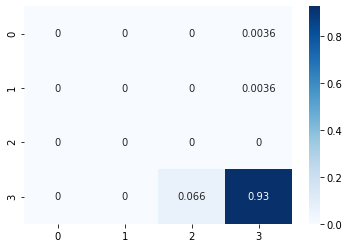

In [19]:
### Given two annotators
group='G4'
base="./IAA/"+group+"/IAA_"
name1="swartjes"
name2="vanderpas"

file1=base+name1+".tsv"
df1 = pd.read_csv(file1,sep="\t")
df1['annotation'].fillna("_")

file2=base+name2+".tsv"
df2 = pd.read_csv(file2,sep="\t")
df2['annotation'].fillna("_")

df1= util.clean_df(df1)
df2= util.clean_df(df2)

sentence_label_dict1 = util.sentence_anno(df1)
sentence_label_dict2 = util.sentence_anno(df2)

setdict1 = util.get_sentence_set_anno_dict(sentence_label_dict1)
setdict2 = util.get_sentence_set_anno_dict(sentence_label_dict2)

anno1 , anno2 = util.get_annotations_for_sentences(setdict1, setdict2, alllabels)
global1 = global1+anno1
global2 = global2+anno2

print('anno1', len(anno1))
print('anno2', len(anno2))


print('global1',len(global1))
print('global2',len(global2))


report1 = classification_report(anno1,anno2,digits = 3)
print(report1)
report2 = classification_report(anno2,anno1,digits = 3)
print(report2)

labels = anno1+anno2
labelset = sorted(set(labels))
cf_matrix = confusion_matrix(anno1, anno2, list(labelset))
print(cf_matrix)
for i, label in enumerate(labelset):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues')


## G5

Length: 6353
Length: 5676
1086
988
Proportion of line mismatches: 0.09023941068139964
anno1 965
anno2 965
global1 4191
global2 4191
              precision    recall  f1-score   support

       STM 1      0.000     0.000     0.000         1
       STM 3      0.000     0.000     0.000         1
           X      0.000     0.000     0.000         0
           _      0.998     0.997     0.997       963

    accuracy                          0.995       965
   macro avg      0.249     0.249     0.249       965
weighted avg      0.996     0.995     0.995       965

              precision    recall  f1-score   support

       STM 1      0.000     0.000     0.000         0
       STM 3      0.000     0.000     0.000         0
           X      0.000     0.000     0.000         3
           _      0.997     0.998     0.997       962

    accuracy                          0.995       965
   macro avg      0.249     0.249     0.249       965
weighted avg      0.994     0.995     0.994       965

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['STM 1', 'STM 3', 'X', '_'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:>

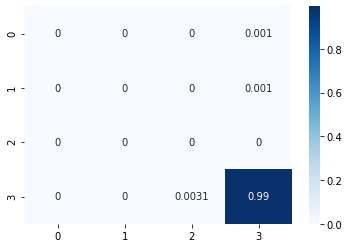

In [20]:
### Given two annotators
group='G5'
base="./IAA/"+group+"/IAA_"
name1="edwin"
name2="sabina"

file1=base+name1+".tsv"
df1 = pd.read_csv(file1,sep="\t")
df1['annotation'].fillna("_")

file2=base+name2+".tsv"
df2 = pd.read_csv(file2,sep="\t")
df2['annotation'].fillna("_")

df1= util.clean_df(df1)
df2= util.clean_df(df2)

sentence_label_dict1 = util.sentence_anno(df1)
sentence_label_dict2 = util.sentence_anno(df2)

setdict1 = util.get_sentence_set_anno_dict(sentence_label_dict1)
setdict2 = util.get_sentence_set_anno_dict(sentence_label_dict2)

anno1 , anno2 = util.get_annotations_for_sentences(setdict1, setdict2, alllabels)
global1 = global1+anno1
global2 = global2+anno2

print('anno1', len(anno1))
print('anno2', len(anno2))


print('global1',len(global1))
print('global2',len(global2))


report1 = classification_report(anno1,anno2,digits = 3)
print(report1)
report2 = classification_report(anno2,anno1,digits = 3)
print(report2)

labels = anno1+anno2
labelset = sorted(set(labels))
cf_matrix = confusion_matrix(anno1, anno2, list(labelset))
print(cf_matrix)
for i, label in enumerate(labelset):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues', xticklabels=True)

## Global

              precision    recall  f1-score   support

       FAC 0      0.000     0.000     0.000         3
       FAC 1      0.000     0.000     0.000         1
       FAC 2      0.000     0.000     0.000         2
       FAC 3      0.000     0.000     0.000         0
       FAC 4      1.000     0.333     0.500         3
       INS 1      1.000     1.000     1.000         1
       STM 0      0.000     0.000     0.000         2
       STM 1      0.000     0.000     0.000         4
       STM 2      0.000     0.000     0.000         1
       STM 3      0.000     0.000     0.000         2
       STM 4      1.000     0.167     0.286         6
           X      0.000     0.000     0.000         0
           _      0.996     0.943     0.969      4166

    accuracy                          0.938      4191
   macro avg      0.307     0.188     0.212      4191
weighted avg      0.993     0.938     0.964      4191

              precision    recall  f1-score   support

       FAC 0      0.000 

<AxesSubplot:>

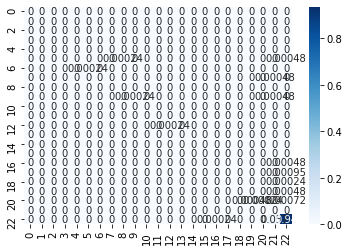

In [22]:
report1 = classification_report(global1,global2,digits = 3)
print(report1)
report2 = classification_report(global2,global1,digits = 3)
print(report2)

labels = global1+global2
labelset = sorted(set(labels))
cf_matrix = confusion_matrix(global1, global2, list(alllabels))
print(cf_matrix)
for i, label in enumerate(alllabels):
    print(i, label)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  cmap='Blues', xticklabels=True)

## Visualise globals

In [33]:
import matplotlib.pyplot as plt
plot_size = plt.rcParams["figure.figsize"]
print('This is the default size:')
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 10
plot_size[1] = 8
print('We change it now to:')
print(plot_size[0]) 
print(plot_size[1])

plt.rcParams["figure.figsize"] = plot_size 

This is the default size:
6.0
4.0
We change it now to:
10
8


<AxesSubplot:>

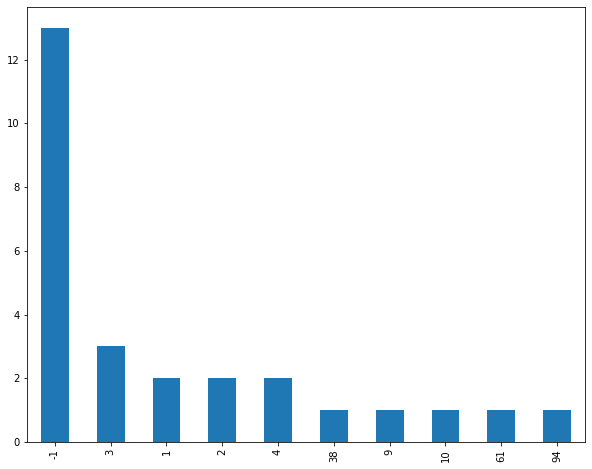

In [34]:
cnts_df.G1.value_counts().sort_values(ascending=False).plot(kind='bar')

## Save the final results to a CSV file

In [35]:
result="iaa.csv"
results_df.to_csv(result)

result="cnts.csv"
cnts_df.to_csv(result)

## Store all paired annotations at sentence level

In [36]:
all_df = pd.DataFrame(list(zip(globalgroup, globalkey, global1, global2)))
all_df.columns =['Key','Group',"label1", "label2"]
all_df.head()

,Key,Group,label1,label2
0,G1,VUmc--5122--1834251--419112434--2020-05-01--q1...,FAC 4,type\_Background
1,G1,VUmc--5117--1834251--418077134--2020-04-27--q1...,.B152: Stemming,STM 3
2,G1,VUmc--5117--1834251--418077134--2020-04-27--q1...,.B152: Stemming,STM 3
3,G1,VUmc--5118--1834251--418315914--2020-04-28--q1...,.B152: Stemming,STM 3
4,G1,VUmc--5122--1834251--419112434--2020-05-01--q1...,.B152: Stemming,STM 3


In [37]:
result="all_pairs.csv"
all_df.to_csv(result)

## Document level

In [38]:
group="ALLDOC"
globals1=[]
globals2=[]
globalskey=[]
globalsgroup=[]

In [39]:
def get_doc_labels (df):
    doc_label_dict1={}
    doc_label_dict2={}
    for index, key in enumerate(df['Key']):
        doc = key[:key.find('_')]
        group = df['Group'].iloc[index]
        label1 = df['label1'].iloc[index]
        label2 = df['label2'].iloc[index]
        if doc in doc_label_dict1:
            doc_label_dict1[doc].append(label1)
        else:
            doc_label_dict1[doc]=[label1]
        
        if doc in doc_label_dict2:
            doc_label_dict2[doc].append(label2)
        else:
            doc_label_dict2[doc]=[label2]
    return doc_label_dict1, doc_label_dict2
 

In [40]:
doc_dict_label1, doc_dict_label2 = get_doc_labels(all_df)

setdict1 = util.get_sentence_set_anno_dict(doc_dict_label1)
setdict2 = util.get_sentence_set_anno_dict(doc_dict_label2)

annotation_list=[]
for key1, value1 in setdict1.items():
    try:
        value2=setdict2[key1]
        for item in value1:
            annotation_list.append(item)
        for item in value2:
            annotation_list.append(item)
    except:
        print('Line mismatch', key1)
        
### Unique set of labels
annotation_labels = set(annotation_list)

kappas={}
cnts = {}
for label in annotation_labels:
    kappa, cnt, l1, l2, k, g =util.get_kappa_for_label(setdict1, setdict2, label, group)
    kappas[label]=kappa
    cnts[label]=cnt
    global1.extend(l1)
    global2.extend(l2)
    globalkey.extend(k)
    globalgroup.extend(g)

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [41]:
print(len(setdict1))
print(len(setdict2))

1
1


In [42]:

doc_results_df = pd.DataFrame(columns=['Label', 'ALLDOC'])

for key, value in kappas.items():
     results_df = util.add_new_row_with_value(results_df, key, value, "ALLDOC")
results_df

,Label,G1,G2,G3,G4,G5,ALLDOC
0,lop\_hulpmiddel,0.143005,-0.132065,0.325302,-1,-1,NaN
1,FAC 1,0.142431,-1,0.312215,-1,-1,0.0
2,type\_Background,0.137186,-0.146555,0.311319,-0.137402,-0.288104,NaN
3,info\_Third party,0.145252,-0.134562,0.3262,-0.0843616,-0.294481,NaN
4,STM 3,0.143085,-1,0.325023,-1,-0.294666,0.0
5,.B455: Inspanningstolerantie,0.145241,-0.095324,0.326995,-1,-0.295193,NaN
6,.B152: Stemming,0.146836,-0.127737,0.32547,-0.0877339,-0.294296,NaN
7,FAC 4,0.144908,-1,-1,-1,-1,NaN
8,stm\_reaction,0.145641,-0.131775,0.349741,-0.0881164,-0.294666,NaN
9,target,0.149687,-0.106329,0.322066,-0.0866779,-0.295869,NaN


## End of this notebook